# SegNet Implementation
[Reference](https://www.kaggle.com/c/data-science-bowl-2018/data) : Kaggle data science bowl 2018 Round 1 <br/>

### Overview
- Goal of SegNet is performing semantic segmentation of road scene.
- Car road and pedestrian road are similar, but it is important to identify each regions.
- The problems of previous segmentation models are that resoution of segmentation map is too low.
- **Subsampling and max-pooling** returns coarse feature map. FCN adopted skip architecture to avoid this problem, but still failed on sophisticated segmentation.
- For Autonomous driving, real-time segmentation is also required. 
- Thus, SegNet is...
    - Efficient in memory and inference time.
    - Fine-grained segmentation model.

### Contribution
- **Max-pooling index transfer for max unpooling** : efficient in memory

### Architecture
- Encoder-Decoder network
- Encoder
    - VGG16 layers except FC layer
- Decoder
    - Encoder-mirrored decoder entwork
    - Pooling > Upsampling layer
    - U-Net fully transfers encoder information : too many parameters, memory consumption
    - **Max-pooling indices** are saved and transferred to decoder. <br/>
    
    <img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbur7XU%2FbtqVugNeD6m%2Fr1Xr2VU0mhLlW1KmOkM730%2Fimg.png" width = "500dp"></img>
- Full architecture <br/>
<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F1SP4O%2FbtqBJfmm7Og%2Fp9KF77ykYOUl5kBR2j8UM0%2Fimg.png" width = "500dp"></img>

In [1]:
import os
import time
import copy
import torch
import shutil
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform
import cv2

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

/home/hahajjjun/anaconda3/envs/molly/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
import sys
sys.executable

'/home/hahajjjun/anaconda3/envs/molly/bin/python'

### Load Data with Dataset

In [3]:
def get_transforms(mean, std):
    list_transforms = []
    list_transforms.extend(
        [
            HorizontalFlip(p=0.5)
        ]
    )
    list_transforms.extend(
        [
            Normalize(mean = mean, std = std, p=1),
            ToTensorV2(),
        ]
    )
    return Compose(list_transforms)

In [4]:
class Nuclei_dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_transforms(0.5, 0.5)
    
    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
        img = io.imread(image_path)[:,:,:3].astype('float32')
        img = transform.resize(img, (128,128))
        mask = self.get_mask(mask_folder, 128, 128).astype('float32')
        augmented = self.transforms(image = img, mask = mask)
        img = augmented['image']
        mask = augmented['mask']
        #print(mask.shape)
        mask = mask.permute(2,0,1)
        
        return (img, mask)
    
    def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask, mask_)
        return mask

In [5]:
base_dir = '/home/hahajjjun/Junha Park/train'
data = Nuclei_dataset(base_dir)


In [6]:
print(data.__len__())
data.__getitem__(0)

670


/tmp/ipykernel_906/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


(tensor([[[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602,

In [7]:
for img, msk in data:
    print(img.shape)
    print(msk.shape)
    break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


/tmp/ipykernel_906/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


In [8]:
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image = std*image + mean
    image = image.clip(0,1)
    image = (image*255).astype(np.uint8)
    return image

In [9]:
trainset, valset = random_split(data, [580, 90])
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

/tmp/ipykernel_906/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


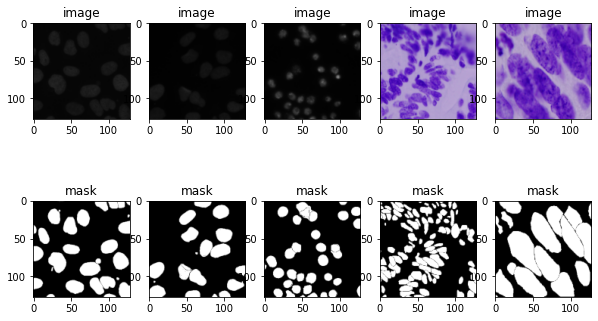

In [10]:
def plot_img(dataloader, no_):
    iter_ = iter(dataloader)
    images, masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(no_):
        image = image_convert(images[idx])
        plt.subplot(2, no_, idx+1)
        plt.title('image')
        plt.imshow(image)
    for idx in range(no_):
        mask = mask_convert(masks[idx])
        plt.subplot(2, no_, idx+no_+1)
        plt.title('mask')
        plt.imshow(mask, cmap='gray')
    plt.show()
    
plot_img(train_loader, 5)

### SegNet : [Reference](https://github.com/vinceecws/SegNet_PyTorch/blob/master/SegNet.py)

In [17]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet,self).__init__()
        self.in_channel = 3
        self.out_channel = 1
        self.bn_momentum = 0.5

        # Encoder

        self.block1 = nn.Sequential(
            nn.Conv2d(self.in_channel, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True)
        )

        # Decoder

        self.max_unpool = nn.MaxUnpool2d(2, stride = 2)
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU()
        )

        self.block7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = self.bn_momentum),
            nn.ReLU()
        )

        self.block8 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128, momentum = self.bn_momentum),
            nn.ReLU()
        )

        self.block9 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64, momentum = self.bn_momentum),
            nn.ReLU()
        )

        self.block10 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64, momentum = self.bn_momentum),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(1, momentum = self.bn_momentum),
            nn.Sigmoid()
        )


    def forward(self, x):
        # Encoder
        x, ind1 = self.block1(x)
        size1 = x.size()
        x, ind2 = self.block2(x)
        size2 = x.size()
        x, ind3 = self.block3(x)
        size3 = x.size()
        x, ind4 = self.block4(x)
        size4 = x.size()
        x, ind5 = self.block5(x)
        # size5 = x.size()
        
        # Decoder
        x = self.max_unpool(x, ind5, output_size = size4)
        x = self.block6(x)
        x = self.max_unpool(x, ind4, output_size = size3)
        x = self.block7(x)
        x = self.max_unpool(x, ind3, output_size = size2)
        x = self.block8(x)
        x = self.max_unpool(x, ind2, output_size = size1)
        x = self.block9(x)
        x = self.max_unpool(x, ind1)
        x = self.block10(x)

        return x

In [18]:
#model = Unet().to(device)
model = SegNet().to(device)
model

SegNet(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128,

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou

def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = F.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou    

In [20]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [21]:
checkpoint_path = '/home/hahajjjun/Junha Park/model'
best_model_path = '/home/hahajjjun/Junha Park/bestmodel/bestmodel.pt'
epochs = 50
criterion = DiceBCELoss()
learning_rate = 1e-2 #1e-3 for unet
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = 3.95275

train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    running_train_score = []
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            pred_mask = model.forward(image) # forward propogation
            #print(pred_mask.shape, mask.shape)
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)
                              

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

                                    
    
    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/50


/tmp/ipykernel_906/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
/home/hahajjjun/anaconda3/envs/molly/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss : 0.7968291856091598 iou : 0.13311319487391324
Validation loss : 0.7709961930910746 iou : 0.13687951442740048
Validation loss decreased (3.952750 --> 0.770996).  Saving model ...
4m 53s
Epoch 2/50
Train loss : 0.761614047247788 iou : 0.1378310106199957
Validation loss : 0.7493530445628696 iou : 0.13950002515812931
Validation loss decreased (0.770996 --> 0.749353).  Saving model ...
4m 53s
Epoch 3/50
Train loss : 0.7370968841273209 iou : 0.14385734873774775
Validation loss : 0.7332586513625251 iou : 0.1419581843699894
Validation loss decreased (0.749353 --> 0.733259).  Saving model ...
4m 57s
Epoch 4/50
Train loss : 0.7283213118026997 iou : 0.14370846922008831
Validation loss : 0.7241910828484429 iou : 0.14331426653249452
Validation loss decreased (0.733259 --> 0.724191).  Saving model ...
4m 51s
Epoch 5/50
Train loss : 0.721889238933037 iou : 0.14449577392496035
Validation loss : 0.720327721701728 iou : 0.14537019251402097
Validation loss decreased (0.724191 --> 0.720328).  

In [1]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

NameError: name 'plt' is not defined

In [17]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

/tmp/ipykernel_17053/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


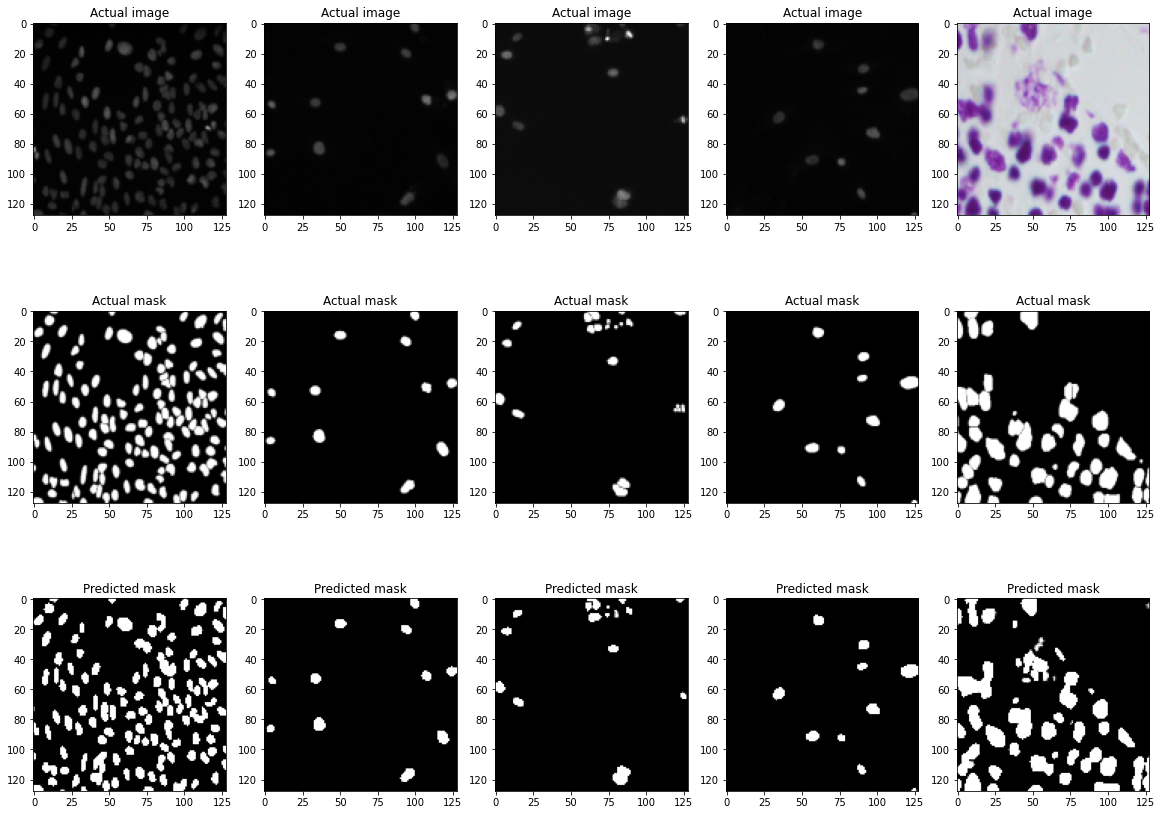

tensor(0.7731, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8305, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6984, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8496, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7530, device='cuda:0', grad_fn=<DivBackward0>)


In [22]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()

for i in range(0,5):
    print(iou_(y_pred[i], mask[i]))